In [50]:
# import all packages and set plots to be embedded inline
import numpy as np
import sklearn.gaussian_process as gp
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut, cross_val_score
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
    X = pd.read_csv('descriptor_data.csv') 

In [3]:
X

,Name,Metal,Atom_A,Atom_B,A-M-B Angle,M-A Distance,M-B Distance,Metal_NBO,A_NBO,B_NBO,...,% VBur asymm 2,% VBur asymm 3,% VBur octant 1,% VBur octant 2,% VBur octant 3,% VBur octant 4,% VBur octant 5,% VBur octant 6,% VBur octant 7,% VBur octant 8
0,ligand-001-n-n-1,2,23,22,80.01004,2.324,2.324,0.26015,-0.42686,-0.42686,...,0.067555,0.051249,79.276929,75.605665,79.304883,75.750093,4.034663,0.242266,3.866940,0.228289
1,ligand-002-p-p-1,2,16,17,81.08750,2.404,2.406,-0.11874,1.06691,1.06830,...,5.049152,3.262439,81.564480,92.051808,83.060007,82.575475,5.101565,8.190458,6.671636,0.535781
2,ligand-003-p-p-2,3,1,12,88.85482,2.393,2.398,-0.12498,1.08763,1.08260,...,0.099003,0.173546,74.021618,74.375699,95.387626,96.706113,8.866008,10.035408,10.860045,10.669027
3,ligand-004-p-p-3,3,45,1,95.97953,2.432,2.441,-0.09320,1.06382,1.05890,...,0.822307,1.202013,97.623928,96.230898,70.308423,71.878494,11.675363,12.486023,18.496086,13.054417
4,ligand-005-c-n-1,1,2,59,86.57124,2.143,2.295,0.17756,0.22924,-0.40636,...,15.149786,30.368291,64.340291,88.292024,40.775252,96.850540,44.781960,9.821096,17.815878,11.330600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,ligand-407-p-o-138,34,1,5,89.32942,2.459,2.263,0.18682,1.04370,-0.96597,...,8.995294,0.404165,98.401975,85.571189,63.939620,73.788669,9.793142,0.843272,26.481551,30.833023
373,ligand-408-p-o-139,34,1,5,89.17718,2.456,2.264,0.18774,1.04308,-0.96762,...,8.058843,0.998183,98.541744,85.613120,64.480060,73.467201,9.900298,0.773388,30.506895,31.699590
374,ligand-409-p-o-140,34,1,5,89.05786,2.465,2.263,0.19732,1.03890,-0.96986,...,8.174152,4.679929,96.706113,86.311964,66.912039,81.387439,11.894335,0.661573,30.138837,26.733135
375,ligand-411-p-o-95,13,1,4,77.82640,2.418,2.292,0.19136,1.04202,-1.08516,...,9.620760,14.170239,82.389117,89.116660,64.591875,97.414275,22.218599,7.459001,19.166977,16.795565


In [44]:
# Create a boolean mask where any column contains the string 'NaN'
mask = X.apply(lambda x: x.astype(str).str.contains('NaN', na=False)).any(axis=1)

# Get the indices of the rows where the mask is True
nan_indices = X[mask].index
missing_values = X.isnull()

# Get the indices of rows with missing values
rows_with_missing = X[X.isnull().any(axis=1)]

# Print the rows with missing values
print("\nRows with missing values:")
print(rows_with_missing)

# Get the indices of rows with missing values
missing_indices = rows_with_missing.index.tolist()

# Remove that indices by dropping
X = X.dropna()

# Add two columns, one with ligand_id, one with donor_atom_combination
# Extract the 3-digit ligand ID and the donor atom combination
X['ligand_id'] = X['Name'].str.extract(r'ligand-(\d{3})')
X['donor_atom_comb'] = X['Name'].str.extract(r'ligand-\d{3}-([a-z]-[a-z])')


Rows with missing values:
Empty DataFrame
Columns: [Name, Metal, Atom_A, Atom_B, A-M-B Angle, M-A Distance, M-B Distance, Metal_NBO, A_NBO, B_NBO, HOMO_LUMO, A-B_NBO, NBO-dist-2-avg, NBO-dist-3-avg, NBO-dist-4-avg, NBO-dist-2-a-avg, NBO-dist-3-a-avg, NBO-dist-4-a-avg, NBO-dist-2-b-avg, NBO-dist-3-b-avg, NBO-dist-4-b-avg, NBO-dist-2-a-b-diff, NBO-dist-3-a-b-diff, NBO-dist-4-a-b-diff, NBO-dist-2-min, NBO-dist-3-min, NBO-dist-4-min, NBO-dist-2-max, NBO-dist-3-max, NBO-dist-4-max, NBO-dist-2-a-min, NBO-dist-3-a-min, NBO-dist-4-a-min, NBO-dist-2-b-min, NBO-dist-3-b-min, NBO-dist-4-b-min, NBO-dist-2-a-max, NBO-dist-3-a-max, NBO-dist-4-a-max, NBO-dist-2-b-max, NBO-dist-3-b-max, NBO-dist-4-b-max, NBO-metal-donor-diff, NBO-metal-a-diff, NBO-metal-b-diff, NBO-dist-2-1-avg-diff, NBO-dist-3-2-avg-diff, NBO-dist-4-3-avg-diff, NBO-dist-2-1-a-avg-diff, NBO-dist-3-2-a-avg-diff, NBO-dist-4-3-a-avg-diff, NBO-dist-2-1-b-avg-diff, NBO-dist-3-2-b-avg-diff, NBO-dist-4-3-b-avg-diff, Metal_mullkien, A_mullik

In [45]:
X

,Name,Metal,Atom_A,Atom_B,A-M-B Angle,M-A Distance,M-B Distance,Metal_NBO,A_NBO,B_NBO,...,% VBur octant 1,% VBur octant 2,% VBur octant 3,% VBur octant 4,% VBur octant 5,% VBur octant 6,% VBur octant 7,% VBur octant 8,ligand_id,donor_atom_comb
1,ligand-002-p-p-1,2,16,17,81.08750,2.404,2.406,-0.11874,1.06691,1.06830,...,81.564480,92.051808,83.060007,82.575475,5.101565,8.190458,6.671636,0.535781,002,p-p
2,ligand-003-p-p-2,3,1,12,88.85482,2.393,2.398,-0.12498,1.08763,1.08260,...,74.021618,74.375699,95.387626,96.706113,8.866008,10.035408,10.860045,10.669027,003,p-p
3,ligand-004-p-p-3,3,45,1,95.97953,2.432,2.441,-0.09320,1.06382,1.05890,...,97.623928,96.230898,70.308423,71.878494,11.675363,12.486023,18.496086,13.054417,004,p-p
4,ligand-005-c-n-1,1,2,59,86.57124,2.143,2.295,0.17756,0.22924,-0.40636,...,64.340291,88.292024,40.775252,96.850540,44.781960,9.821096,17.815878,11.330600,005,c-n
5,ligand-006-c-n-2,1,2,44,86.23337,2.145,2.253,0.17159,0.23504,-0.40535,...,68.766306,82.636042,51.118151,87.183190,25.987700,0.475214,14.018822,9.122251,006,c-n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,ligand-407-p-o-138,34,1,5,89.32942,2.459,2.263,0.18682,1.04370,-0.96597,...,98.401975,85.571189,63.939620,73.788669,9.793142,0.843272,26.481551,30.833023,407,p-o
373,ligand-408-p-o-139,34,1,5,89.17718,2.456,2.264,0.18774,1.04308,-0.96762,...,98.541744,85.613120,64.480060,73.467201,9.900298,0.773388,30.506895,31.699590,408,p-o
374,ligand-409-p-o-140,34,1,5,89.05786,2.465,2.263,0.19732,1.03890,-0.96986,...,96.706113,86.311964,66.912039,81.387439,11.894335,0.661573,30.138837,26.733135,409,p-o
375,ligand-411-p-o-95,13,1,4,77.82640,2.418,2.292,0.19136,1.04202,-1.08516,...,82.389117,89.116660,64.591875,97.414275,22.218599,7.459001,19.166977,16.795565,411,p-o


In [46]:
print(type(X['A-B_NBO']))
A_B_NBO_values = X['A-B_NBO'].tolist()
float_values = [float(value) for value in A_B_NBO_values]
names = X['Name'].tolist()
ligand_id = X['ligand_id'].tolist()
donor_atom_comb = X['donor_atom_comb'].tolist()
X_2 = X.drop(['Name', 'Metal','Atom_A', 'Atom_B','ligand_id','donor_atom_comb'], axis=1)

<class 'pandas.core.series.Series'>


In [20]:
percent_buried_volume = X['Total % VBur']
percent_buried_volume = [float(value) for value in percent_buried_volume]

### Generate PCA map with all descriptors

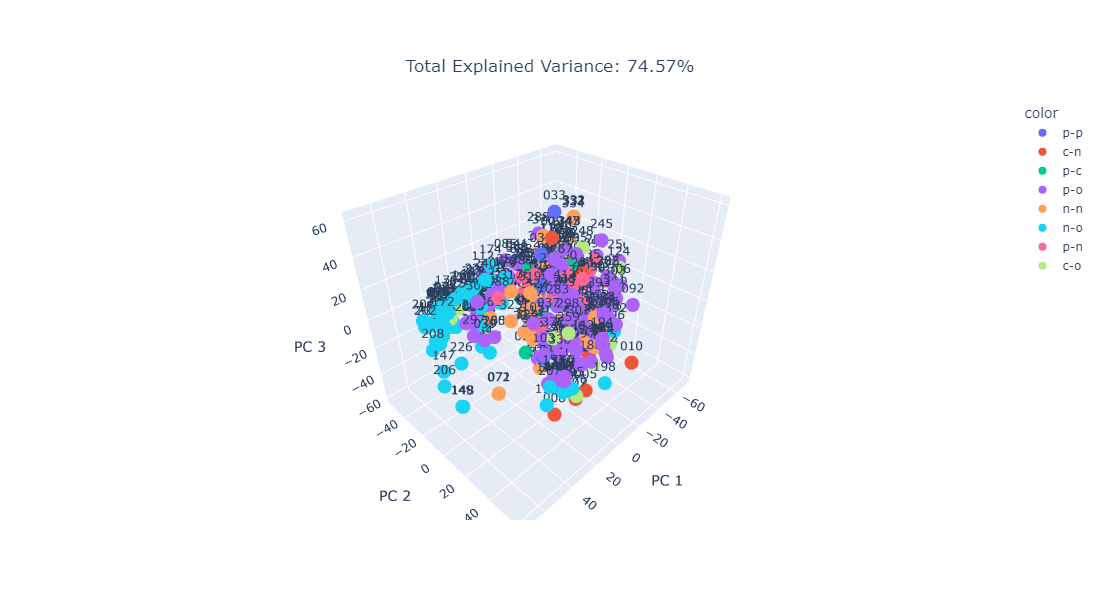

In [80]:

# Generate PCA map with ALL descriptors - find out cluster combinations through this

pca = PCA(n_components=3)
components = pca.fit_transform(X_2)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    text=ligand_id,
    color = donor_atom_comb,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)

fig.update_layout(width=800, 
                  height=600,
                  coloraxis_colorbar=dict(
                  title=dict(text="Percent Buried<br>Volume",
                             side="top"),
                  x=0.85,  # Position the legend closer to the scatter plot
                  y=0.5,
                  xanchor='left',
                  yanchor='middle'),
                  title=dict(
                  x=0.5,          # Horizontal position (centered)
                  y=0.9,          # Vertical position (closer to the plot)
                  xanchor='center',
                  yanchor='top'
                    ) 
                 )
fig.show()

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 2, the average silhouette score is 0.332912449346667


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 3, the average silhouette score is 0.3642389911195937


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 4, the average silhouette score is 0.346057909975104


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 5, the average silhouette score is 0.3642408839023856


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 6, the average silhouette score is 0.33420773688670613


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 7, the average silhouette score is 0.3099752906252201


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 8, the average silhouette score is 0.30651448478245


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 9, the average silhouette score is 0.29730398842965866


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 10, the average silhouette score is 0.3082241785876624


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 11, the average silhouette score is 0.3153758151234942


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 12, the average silhouette score is 0.2878691989807568


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 13, the average silhouette score is 0.3315326308324646


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 14, the average silhouette score is 0.30586309357820335


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 15, the average silhouette score is 0.29600869757342396


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 16, the average silhouette score is 0.30621342310965366


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 17, the average silhouette score is 0.32745068471836786


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 18, the average silhouette score is 0.3226305250377543


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 19, the average silhouette score is 0.32143951188907943

The optimal number of clusters is 5 with a silhouette score of 0.3642408839023856


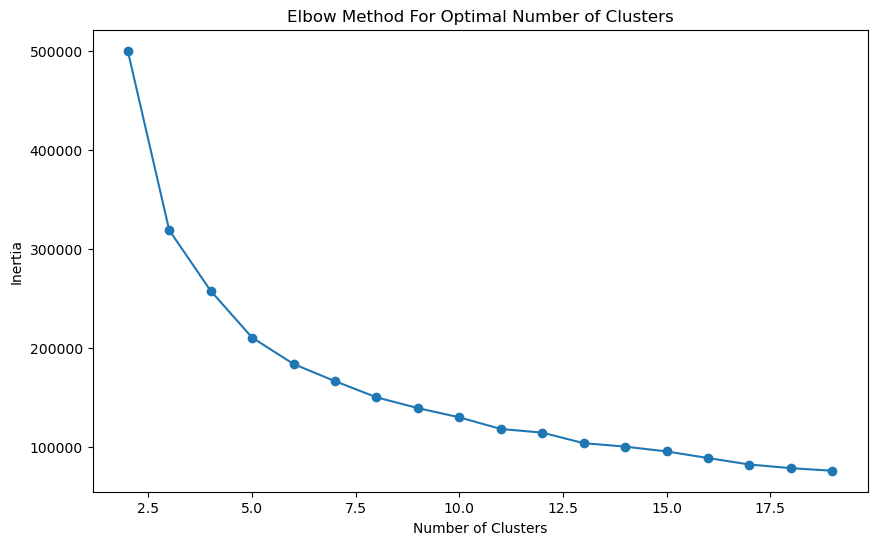


PCA Result DataFrame with Cluster Labels:
           PC1        PC2        PC3  Cluster Ligand
0     3.689471  -5.086006  -7.133747        4    NaN
1    -8.700032  -4.439363   6.693798        4    002
2   -16.045081  -0.364023  -6.631076        2    003
3   -15.391295  26.005289 -57.717494        2    004
4     5.067326  27.849428 -39.823364        2    005
..         ...        ...        ...      ...    ...
371 -18.630044  19.682288  -7.110051        2    406
372 -20.878137  17.579001  -8.174826        2    407
373 -24.463510  15.813892 -12.295583        2    408
374 -25.573103  13.756002 -26.277375        2    409
375   3.590266  22.825549  24.251511        4    411

[376 rows x 5 columns]
{'c1': ['038', '072', '073', '074', '075', '076', '077', '078', '092', '099', '111', '121', '122', '145', '146', '149', '150', '151', '160', '161', '168', '169', '170', '171', '172', '173', '174', '177', '178', '179', '180', '181', '182', '183', '186', '199', '200', '201', '202', '205', '207', '2

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [81]:
# Generate dataframe from pca data: 
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2','PC3'])

# Apply KMeans Clustering
# Define a range of clusters to evaluate
range_n_clusters = list(range(2, 20))

# Initialize variables to store the best number of clusters and corresponding metrics
best_n_clusters = 0
best_silhouette_score = -1
inertia = []

# Iterate over different cluster numbers to find the optimal number
for n_clusters in range_n_clusters:
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    # Calculate silhouette score
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    inertia.append(kmeans.inertia_)
    
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg}")
    
    # Update the best silhouette score and corresponding number of clusters
    if silhouette_avg > best_silhouette_score:
        best_n_clusters = n_clusters
        best_silhouette_score = silhouette_avg

# Print the optimal number of clusters and the best silhouette score
print(f"\nThe optimal number of clusters is {best_n_clusters} with a silhouette score of {best_silhouette_score}")

# Plot the inertia to visualize the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)

# Add cluster labels to the PCA result DataFrame
pca_df['Cluster'] = cluster_labels
pca_df['Ligand'] = X['ligand_id']


# Print the PCA result DataFrame with cluster labels
print("\nPCA Result DataFrame with Cluster Labels:")
print(pca_df)


# Create a dictionary to store clusters and their corresponding ligands
cluster_dict_all_descriptor = {}
for cluster_num in range(best_n_clusters):
    cluster_key = f'c{cluster_num + 1}'  # Create cluster key like 'c1', 'c2', etc.
    ligands_in_cluster = pca_df[pca_df['Cluster'] == cluster_num]['Ligand'].tolist()
    cluster_dict_all_descriptor[cluster_key] = ligands_in_cluster

# Print the dictionary
print(cluster_dict_all_descriptor)

In [82]:
#Obtain only nbo based descriptor X_nbo
# Obtain only percent buried volume based descriptor X_Vbur 

X_2_columns = X_2.columns
print(X_2_columns)

nbo_list = ['Metal_NBO', 'A_NBO', 'B_NBO', 'HOMO_LUMO', 'A-B_NBO',
       'NBO-dist-2-avg', 'NBO-dist-3-avg', 'NBO-dist-4-avg',
       'NBO-dist-2-a-avg', 'NBO-dist-3-a-avg', 'NBO-dist-4-a-avg',
       'NBO-dist-2-b-avg', 'NBO-dist-3-b-avg', 'NBO-dist-4-b-avg',
       'NBO-dist-2-a-b-diff', 'NBO-dist-3-a-b-diff', 'NBO-dist-4-a-b-diff',
       'NBO-dist-2-min', 'NBO-dist-3-min', 'NBO-dist-4-min', 'NBO-dist-2-max',
       'NBO-dist-3-max', 'NBO-dist-4-max', 'NBO-dist-2-a-min',
       'NBO-dist-3-a-min', 'NBO-dist-4-a-min', 'NBO-dist-2-b-min',
       'NBO-dist-3-b-min', 'NBO-dist-4-b-min', 'NBO-dist-2-a-max',
       'NBO-dist-3-a-max', 'NBO-dist-4-a-max', 'NBO-dist-2-b-max',
       'NBO-dist-3-b-max', 'NBO-dist-4-b-max', 'NBO-metal-donor-diff',
       'NBO-metal-a-diff', 'NBO-metal-b-diff', 'NBO-dist-2-1-avg-diff',
       'NBO-dist-3-2-avg-diff', 'NBO-dist-4-3-avg-diff',
       'NBO-dist-2-1-a-avg-diff', 'NBO-dist-3-2-a-avg-diff',
       'NBO-dist-4-3-a-avg-diff', 'NBO-dist-2-1-b-avg-diff',
       'NBO-dist-3-2-b-avg-diff', 'NBO-dist-4-3-b-avg-diff', 'Metal_mullkien',
       'A_mulliken', 'B_mulliken', 'A-B_mulliken', 'Mulliken-dist-2-avg',
       'Mulliken-dist-3-avg', 'Mulliken-dist-4-avg']


vbur_list = ['Total % VBur', '% VBur SE',
       '% VBur SW', '% VBur NE', '% VBur NW', '% VBur max', '% VBur min',
       '% VBur max min diff', '% VBur NE NW diff', '% VBur SE SW diff',
       '% VBur NE SE diff', '% VBur NW SW diff', '% VBur NE SW diff',
       '% VBur NW SE diff', '% VBur asymm 1', '% VBur asymm 2',
       '% VBur asymm 3', '% VBur octant 1', '% VBur octant 2',
       '% VBur octant 3', '% VBur octant 4', '% VBur octant 5',
       '% VBur octant 6', '% VBur octant 7', '% VBur octant 8']

X_nbo = X_2[nbo_list]
X_vbur = X_2[vbur_list]

Index(['A-M-B Angle', 'M-A Distance', 'M-B Distance', 'Metal_NBO', 'A_NBO',
       'B_NBO', 'HOMO_LUMO', 'A-B_NBO', 'NBO-dist-2-avg', 'NBO-dist-3-avg',
       'NBO-dist-4-avg', 'NBO-dist-2-a-avg', 'NBO-dist-3-a-avg',
       'NBO-dist-4-a-avg', 'NBO-dist-2-b-avg', 'NBO-dist-3-b-avg',
       'NBO-dist-4-b-avg', 'NBO-dist-2-a-b-diff', 'NBO-dist-3-a-b-diff',
       'NBO-dist-4-a-b-diff', 'NBO-dist-2-min', 'NBO-dist-3-min',
       'NBO-dist-4-min', 'NBO-dist-2-max', 'NBO-dist-3-max', 'NBO-dist-4-max',
       'NBO-dist-2-a-min', 'NBO-dist-3-a-min', 'NBO-dist-4-a-min',
       'NBO-dist-2-b-min', 'NBO-dist-3-b-min', 'NBO-dist-4-b-min',
       'NBO-dist-2-a-max', 'NBO-dist-3-a-max', 'NBO-dist-4-a-max',
       'NBO-dist-2-b-max', 'NBO-dist-3-b-max', 'NBO-dist-4-b-max',
       'NBO-metal-donor-diff', 'NBO-metal-a-diff', 'NBO-metal-b-diff',
       'NBO-dist-2-1-avg-diff', 'NBO-dist-3-2-avg-diff',
       'NBO-dist-4-3-avg-diff', 'NBO-dist-2-1-a-avg-diff',
       'NBO-dist-3-2-a-avg-diff', 'NBO-dist

In [83]:
X_vbur

,Total % VBur,% VBur SE,% VBur SW,% VBur NE,% VBur NW,% VBur max,% VBur min,% VBur max min diff,% VBur NE NW diff,% VBur SE SW diff,...,% VBur asymm 2,% VBur asymm 3,% VBur octant 1,% VBur octant 2,% VBur octant 3,% VBur octant 4,% VBur octant 5,% VBur octant 6,% VBur octant 7,% VBur octant 8
1,44.968901,41.050130,49.361722,43.838520,45.625233,49.361722,41.050130,8.311592,44.731877,45.205926,...,5.049152,3.262439,81.564480,92.051808,83.060007,82.575475,5.101565,8.190458,6.671636,0.535781
2,47.615193,42.345322,42.617872,52.786060,52.711517,52.786060,42.345322,10.440738,52.748789,42.481597,...,0.099003,0.173546,74.021618,74.375699,95.387626,96.706113,8.866008,10.035408,10.860045,10.669027
3,48.969204,55.339173,57.363492,41.776929,41.397223,57.363492,41.397223,15.966269,41.587076,56.351332,...,0.822307,1.202013,97.623928,96.230898,70.308423,71.878494,11.675363,12.486023,18.496086,13.054417
4,46.750955,37.835445,53.053951,70.816250,25.298174,70.816250,25.298174,45.518077,48.057212,45.444698,...,15.149786,30.368291,64.340291,88.292024,40.775252,96.850540,44.781960,9.821096,17.815878,11.330600
5,42.413460,38.944279,48.327432,56.585445,25.796683,56.585445,25.796683,30.788763,41.191064,43.635855,...,10.702805,20.085958,68.766306,82.636042,51.118151,87.183190,25.987700,0.475214,14.018822,9.122251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,48.706555,64.617499,56.026370,41.790906,32.391446,64.617499,32.391446,32.226053,37.091176,60.321934,...,8.995294,0.404165,98.401975,85.571189,63.939620,73.788669,9.793142,0.843272,26.481551,30.833023
373,49.372787,65.120667,58.060007,41.683750,32.626724,65.120667,32.626724,32.493943,37.155237,61.590337,...,8.058843,0.998183,98.541744,85.613120,64.480060,73.467201,9.900298,0.773388,30.506895,31.699590
374,50.093179,61.719624,58.225401,46.640887,33.786806,61.719624,33.786806,27.932818,40.213846,59.972512,...,8.174152,4.679929,96.706113,86.311964,66.912039,81.387439,11.894335,0.661573,30.138837,26.733135
375,49.894009,49.592341,54.141819,59.816437,36.025438,59.816437,36.025438,23.790999,47.920937,51.867080,...,9.620760,14.170239,82.389117,89.116660,64.591875,97.414275,22.218599,7.459001,19.166977,16.795565


### Generate PCA map with V_bur descriptors - find out cluster combinations through this

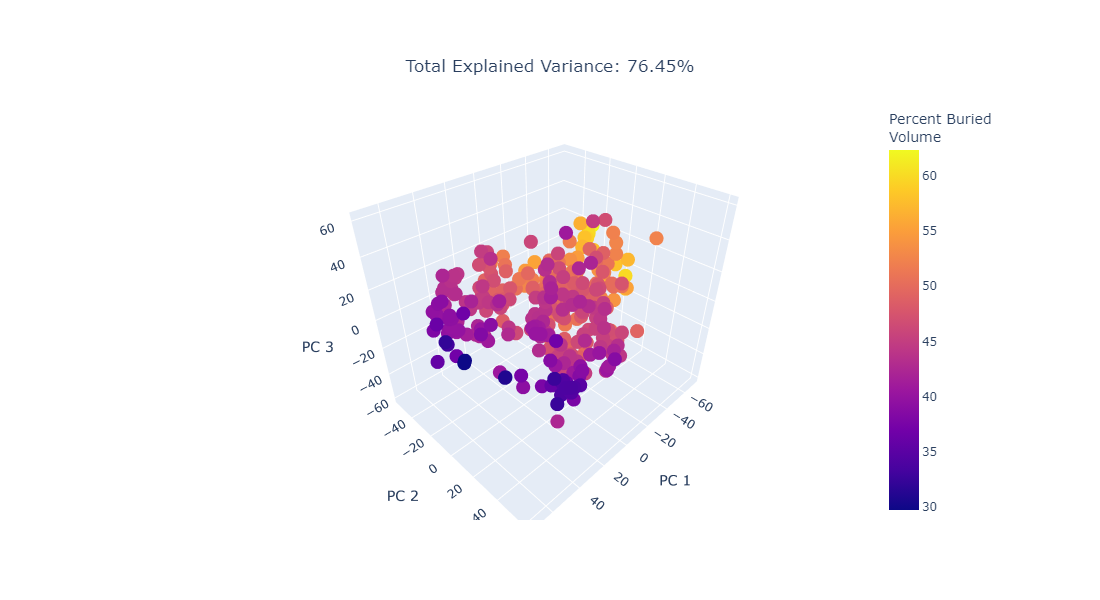

In [84]:
A_B_NBO_values = X_nbo['A-B_NBO'].tolist()
float_values = [float(value) for value in A_B_NBO_values]

A_NBO_values = X_nbo['A_NBO'].tolist()
float_values = [float(value) for value in A_NBO_values]

vbur_values = X_vbur['Total % VBur'].tolist()
vbur_values = [float(value) for value in vbur_values]

vbur_max_values = X_vbur['% VBur max'].tolist()
vbur_max_values = [float(value) for value in vbur_max_values]

pca = PCA(n_components=3)
components = pca.fit_transform(X_vbur)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    # text=names,
    color = percent_buried_volume,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)

fig.update_layout(width=800, 
                  height=600,
                  coloraxis_colorbar=dict(
                  title=dict(text="Percent Buried<br>Volume",
                             side="top"),
                  x=0.85,  # Position the legend closer to the scatter plot
                  y=0.5,
                  xanchor='left',
                  yanchor='middle'),
                  title=dict(
                  x=0.5,          # Horizontal position (centered)
                  y=0.9,          # Vertical position (closer to the plot)
                  xanchor='center',
                  yanchor='top'
                    ) 
                 )
fig.show()

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 2, the average silhouette score is 0.33344233789882544


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 3, the average silhouette score is 0.3647145926571277


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 4, the average silhouette score is 0.34944822592558616


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 5, the average silhouette score is 0.3643165263047619


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 6, the average silhouette score is 0.33172382177076415


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 7, the average silhouette score is 0.3309404089592618


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 8, the average silhouette score is 0.2932356554062508


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 9, the average silhouette score is 0.30804303302355945


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 10, the average silhouette score is 0.3044609762039521


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 11, the average silhouette score is 0.31542957620228884


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 12, the average silhouette score is 0.2983134339921561


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 13, the average silhouette score is 0.3270701838092892


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 14, the average silhouette score is 0.31090776954740623


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 15, the average silhouette score is 0.32486569623654726


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 16, the average silhouette score is 0.31685620512463514


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 17, the average silhouette score is 0.3154144969621037


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 18, the average silhouette score is 0.31682162019223864


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 19, the average silhouette score is 0.3184653039781163

The optimal number of clusters is 3 with a silhouette score of 0.3647145926571277


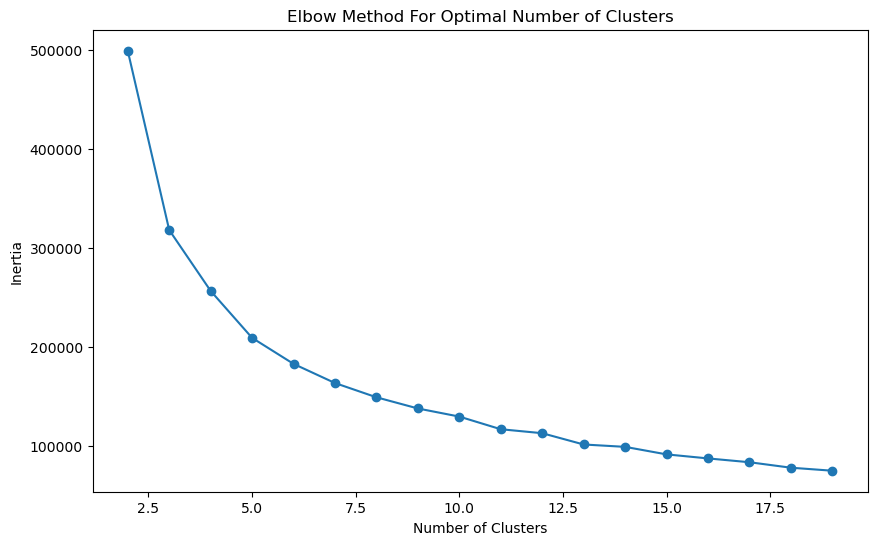


PCA Result DataFrame with Cluster Labels:
           PC1        PC2        PC3  Cluster Ligand
0     3.693650  -5.061245   6.767247        2    NaN
1    -8.644768  -4.311412  -6.470653        1    002
2   -15.888863  -0.176192   7.600570        1    003
3   -15.358850  26.183543  58.773503        2    004
4     5.110844  27.947913  40.396662        2    005
..         ...        ...        ...      ...    ...
371 -18.414279  19.674493   8.110057        2    406
372 -20.671890  17.578170   9.181137        2    407
373 -24.268662  15.824961  13.167304        1    408
374 -25.438013  13.691229  26.295564        1    409
375   3.801941  22.786031 -23.429120        2    411

[376 rows x 5 columns]
{'c1': ['038', '048', '072', '073', '074', '075', '076', '077', '078', '092', '099', '111', '121', '122', '145', '146', '147', '148', '149', '150', '151', '160', '161', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '186', '199', '2

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [85]:
# Generate dataframe from pca data: 
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2','PC3'])

# Apply KMeans Clustering
# Define a range of clusters to evaluate
range_n_clusters = list(range(2, 20))

# Initialize variables to store the best number of clusters and corresponding metrics
best_n_clusters = 0
best_silhouette_score = -1
inertia = []

# Iterate over different cluster numbers to find the optimal number
for n_clusters in range_n_clusters:
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    # Calculate silhouette score
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    inertia.append(kmeans.inertia_)
    
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg}")
    
    # Update the best silhouette score and corresponding number of clusters
    if silhouette_avg > best_silhouette_score:
        best_n_clusters = n_clusters
        best_silhouette_score = silhouette_avg

# Print the optimal number of clusters and the best silhouette score
print(f"\nThe optimal number of clusters is {best_n_clusters} with a silhouette score of {best_silhouette_score}")

# Plot the inertia to visualize the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)

# Add cluster labels to the PCA result DataFrame
pca_df['Cluster'] = cluster_labels
pca_df['Ligand'] = X['ligand_id']


# Print the PCA result DataFrame with cluster labels
print("\nPCA Result DataFrame with Cluster Labels:")
print(pca_df)


# Create a dictionary to store clusters and their corresponding ligands
cluster_dict_vbur_descriptor = {}
for cluster_num in range(best_n_clusters):
    cluster_key = f'c{cluster_num + 1}'  # Create cluster key like 'c1', 'c2', etc.
    ligands_in_cluster = pca_df[pca_df['Cluster'] == cluster_num]['Ligand'].tolist()
    cluster_dict_vbur_descriptor[cluster_key] = ligands_in_cluster

# Print the dictionary
print(cluster_dict_vbur_descriptor)

### Generate PCA map with NBO descriptors - find out cluster combinations through this

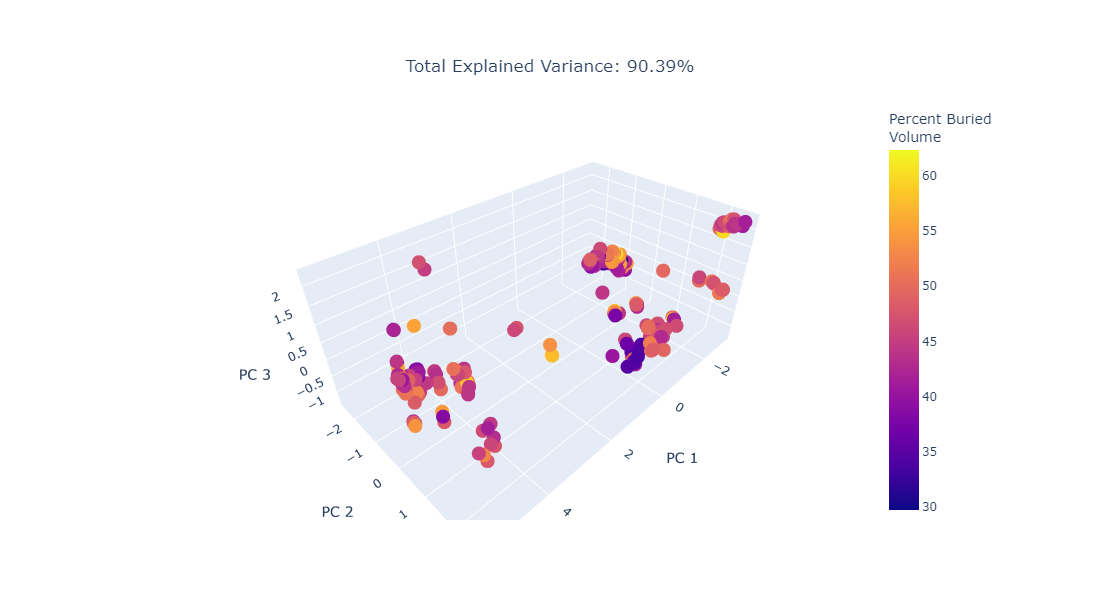

In [86]:
A_B_NBO_values = X_nbo['A-B_NBO'].tolist()
float_values = [float(value) for value in A_B_NBO_values]

A_NBO_values = X_nbo['A_NBO'].tolist()
float_values = [float(value) for value in A_NBO_values]


NBO_dist_2_a_b_diff = X_nbo['NBO-dist-2-a-b-diff'].tolist()
NBO_dist_2_a_b_diff = [float(value) for value in NBO_dist_2_a_b_diff]

NBO_dist_3_2_b_avg_diff = X_nbo['NBO-dist-3-2-b-avg-diff'].tolist()
NBO_dist_3_2_b_avg_diff = [float(value) for value in NBO_dist_2_a_b_diff]

vbur_octant_2 = X_2['% VBur octant 2'].tolist()
vbur_octant_2 = [float(value) for value in vbur_octant_2]


#Create PCA Plot in 3D
pca = PCA(n_components=3)
components = pca.fit_transform(X_nbo)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components,
    x=0,
    y=1,
    z=2,
    # text=names,
    color = percent_buried_volume,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)

fig.update_layout(width=800, 
                  height=600,
                  coloraxis_colorbar=dict(
                  title=dict(text="Percent Buried<br>Volume",
                             side="top"),
                  x=0.85,  # Position the legend closer to the scatter plot
                  y=0.5,
                  xanchor='left',
                  yanchor='middle'),
                  title=dict(
                  x=0.5,          # Horizontal position (centered)
                  y=0.9,          # Vertical position (closer to the plot)
                  xanchor='center',
                  yanchor='top'
                    ) 
                 )
fig.show()

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 2, the average silhouette score is 0.721307541563031


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 3, the average silhouette score is 0.6764917127083537


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 4, the average silhouette score is 0.7389933874334447


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 5, the average silhouette score is 0.6661118754550118


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 6, the average silhouette score is 0.6230669898714697


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 7, the average silhouette score is 0.6306069011370585


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 8, the average silhouette score is 0.6516709852582935


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 9, the average silhouette score is 0.5876716242151697


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 10, the average silhouette score is 0.6661770652728465


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 11, the average silhouette score is 0.6128058390859381


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 12, the average silhouette score is 0.62190972443897


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 13, the average silhouette score is 0.6006524231736567


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 14, the average silhouette score is 0.603591350443035


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 15, the average silhouette score is 0.6012220090034905


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 16, the average silhouette score is 0.6115674236475351


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 17, the average silhouette score is 0.5951047038270281


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 18, the average silhouette score is 0.616667014306981


C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



For n_clusters = 19, the average silhouette score is 0.6198182494227539

The optimal number of clusters is 4 with a silhouette score of 0.7389933874334447


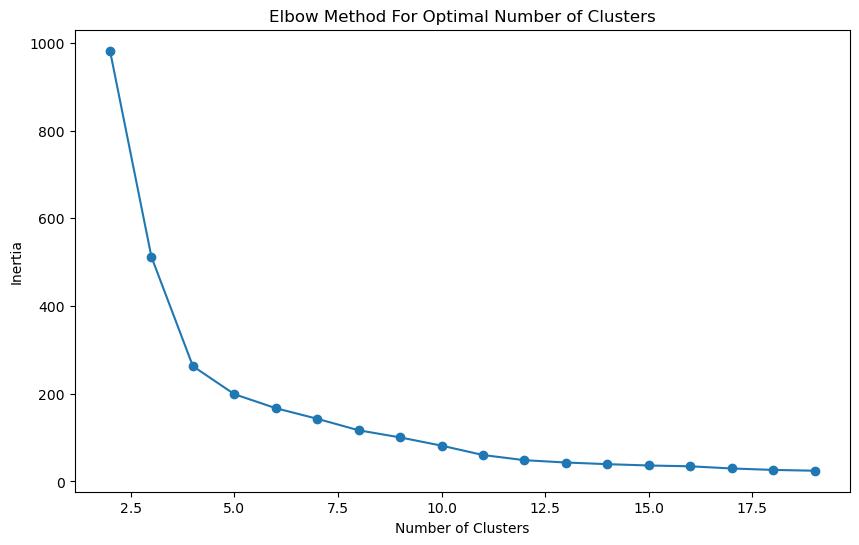


PCA Result DataFrame with Cluster Labels:
          PC1       PC2       PC3  Cluster Ligand
0   -2.868745  2.033627  1.991181        2    NaN
1   -2.871057  2.004605  1.973114        2    002
2   -2.872544  1.979464  1.913940        2    003
3   -2.130146  0.288102 -0.874482        0    004
4   -2.113748  0.297505 -0.888563        0    005
..        ...       ...       ...      ...    ...
371  5.169584 -0.283784  0.219393        1    406
372  5.169961 -0.284650  0.220590        1    407
373  5.168800 -0.293140  0.223108        1    408
374  4.501760 -0.024606 -0.007489        1    409
375  4.452521 -0.264406  0.326279        1    411

[376 rows x 5 columns]
{'c1': ['004', '005', '006', '007', '008', '009', '010', '058', '060', '071', '072', '073', '074', '075', '076', '077', '078', '112', '113', '114', '115', '116', '129', '139', '140', '141', '142', '145', '146', '147', '148', '149', '150', '151', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '17

C:\Users\George\.conda\envs\chem3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



In [87]:
# Generate dataframe from pca data: 
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2','PC3'])

# Apply KMeans Clustering
# Define a range of clusters to evaluate
range_n_clusters = list(range(2, 20))

# Initialize variables to store the best number of clusters and corresponding metrics
best_n_clusters = 0
best_silhouette_score = -1
inertia = []

# Iterate over different cluster numbers to find the optimal number
for n_clusters in range_n_clusters:
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df)
    # Calculate silhouette score
    silhouette_avg = silhouette_score(pca_df, cluster_labels)
    inertia.append(kmeans.inertia_)
    
    print(f"For n_clusters = {n_clusters}, the average silhouette score is {silhouette_avg}")
    
    # Update the best silhouette score and corresponding number of clusters
    if silhouette_avg > best_silhouette_score:
        best_n_clusters = n_clusters
        best_silhouette_score = silhouette_avg

# Print the optimal number of clusters and the best silhouette score
print(f"\nThe optimal number of clusters is {best_n_clusters} with a silhouette score of {best_silhouette_score}")

# Plot the inertia to visualize the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Apply KMeans with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)

# Add cluster labels to the PCA result DataFrame
pca_df['Cluster'] = cluster_labels
pca_df['Ligand'] = X['ligand_id']


# Print the PCA result DataFrame with cluster labels
print("\nPCA Result DataFrame with Cluster Labels:")
print(pca_df)


# Create a dictionary to store clusters and their corresponding ligands
cluster_dict_nbo_descriptor = {}
for cluster_num in range(best_n_clusters):
    cluster_key = f'c{cluster_num + 1}'  # Create cluster key like 'c1', 'c2', etc.
    ligands_in_cluster = pca_df[pca_df['Cluster'] == cluster_num]['Ligand'].tolist()
    cluster_dict_nbo_descriptor[cluster_key] = ligands_in_cluster

# Print the dictionary
print(cluster_dict_nbo_descriptor)

In [92]:
import json 

data = {
    'cluster_dict_all_descriptor' : cluster_dict_all_descriptor,
    'cluster_dict_nbo_descriptor' : cluster_dict_nbo_descriptor,
    'cluster_dict_vbur_descriptor' : cluster_dict_vbur_descriptor
    }

# Convert the combined dictionary to a JSON string
json_data = json.dumps(data)

# Write the JSON string to a .txt file
with open('cluster_dictionaries.txt', 'w') as file:
    file.write(json_data)

In [88]:
cluster_dict_all_descriptor

{'c1': ['038',
  '072',
  '073',
  '074',
  '075',
  '076',
  '077',
  '078',
  '092',
  '099',
  '111',
  '121',
  '122',
  '145',
  '146',
  '149',
  '150',
  '151',
  '160',
  '161',
  '168',
  '169',
  '170',
  '171',
  '172',
  '173',
  '174',
  '177',
  '178',
  '179',
  '180',
  '181',
  '182',
  '183',
  '186',
  '199',
  '200',
  '201',
  '202',
  '205',
  '207',
  '208',
  '209',
  '210',
  '211',
  '212',
  '213',
  '214',
  '215',
  '216',
  '217',
  '218',
  '219',
  '220',
  '221',
  '222',
  '223',
  '224',
  '225',
  '226',
  '227',
  '228',
  '229',
  '230',
  '231',
  '237',
  '238',
  '239',
  '240',
  '241',
  '250',
  '251',
  '252',
  '254',
  '257',
  '259',
  '264',
  '265',
  '296',
  '299',
  '301',
  '303',
  '309',
  '310',
  '311',
  '312',
  '348',
  '350',
  '353',
  '356',
  '357',
  '358',
  '359',
  '360',
  '387'],
 'c2': ['022',
  '031',
  '040',
  '042',
  '053',
  '056',
  '057',
  '058',
  '084',
  '085',
  '086',
  '087',
  '089',
  '090',
  '096

In [90]:
cluster_dict_nbo_descriptor

{'c1': ['004',
  '005',
  '006',
  '007',
  '008',
  '009',
  '010',
  '058',
  '060',
  '071',
  '072',
  '073',
  '074',
  '075',
  '076',
  '077',
  '078',
  '112',
  '113',
  '114',
  '115',
  '116',
  '129',
  '139',
  '140',
  '141',
  '142',
  '145',
  '146',
  '147',
  '148',
  '149',
  '150',
  '151',
  '160',
  '161',
  '162',
  '163',
  '164',
  '165',
  '166',
  '167',
  '168',
  '169',
  '170',
  '171',
  '172',
  '173',
  '174',
  '175',
  '176',
  '177',
  '178',
  '179',
  '180',
  '181',
  '195',
  '196',
  '197',
  '198',
  '199',
  '200',
  '201',
  '202',
  '203',
  '204',
  '205',
  '206',
  '207',
  '208',
  '209',
  '210',
  '211',
  '212',
  '213',
  '214',
  '215',
  '216',
  '217',
  '218',
  '219',
  '220',
  '221',
  '222',
  '223',
  '224',
  '225',
  '226',
  '227',
  '228',
  '229',
  '230',
  '231',
  '237',
  '238',
  '239',
  '240',
  '241',
  '256',
  '257',
  '275',
  '276',
  '306',
  '307',
  '308',
  '313',
  '314',
  '316',
  '317',
  '318',
  '3

In [91]:
cluster_dict_vbur_descriptor

{'c1': ['038',
  '048',
  '072',
  '073',
  '074',
  '075',
  '076',
  '077',
  '078',
  '092',
  '099',
  '111',
  '121',
  '122',
  '145',
  '146',
  '147',
  '148',
  '149',
  '150',
  '151',
  '160',
  '161',
  '168',
  '169',
  '170',
  '171',
  '172',
  '173',
  '174',
  '175',
  '176',
  '177',
  '178',
  '179',
  '180',
  '181',
  '182',
  '183',
  '186',
  '199',
  '200',
  '201',
  '202',
  '205',
  '207',
  '208',
  '209',
  '210',
  '211',
  '212',
  '213',
  '214',
  '215',
  '216',
  '217',
  '218',
  '219',
  '220',
  '221',
  '222',
  '223',
  '224',
  '225',
  '226',
  '227',
  '228',
  '229',
  '230',
  '231',
  '237',
  '238',
  '239',
  '240',
  '241',
  '250',
  '251',
  '252',
  '254',
  '257',
  '259',
  '264',
  '265',
  '296',
  '299',
  '301',
  '303',
  '309',
  '310',
  '311',
  '312',
  '348',
  '350',
  '353',
  '356',
  '357',
  '358',
  '359',
  '360',
  '387'],
 'c2': ['002',
  '003',
  '011',
  '013',
  '018',
  '019',
  '020',
  '021',
  '022',
  '030